<a href="https://colab.research.google.com/github/Agtna/Visi-Komputer-2025-/blob/main/Jobsheet3_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

###1)Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

###2)“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

Tugas kecil: Lihat gambar-gambar berikut. Kira-kira variabel kontinu apa yang ingin kita prediksi?

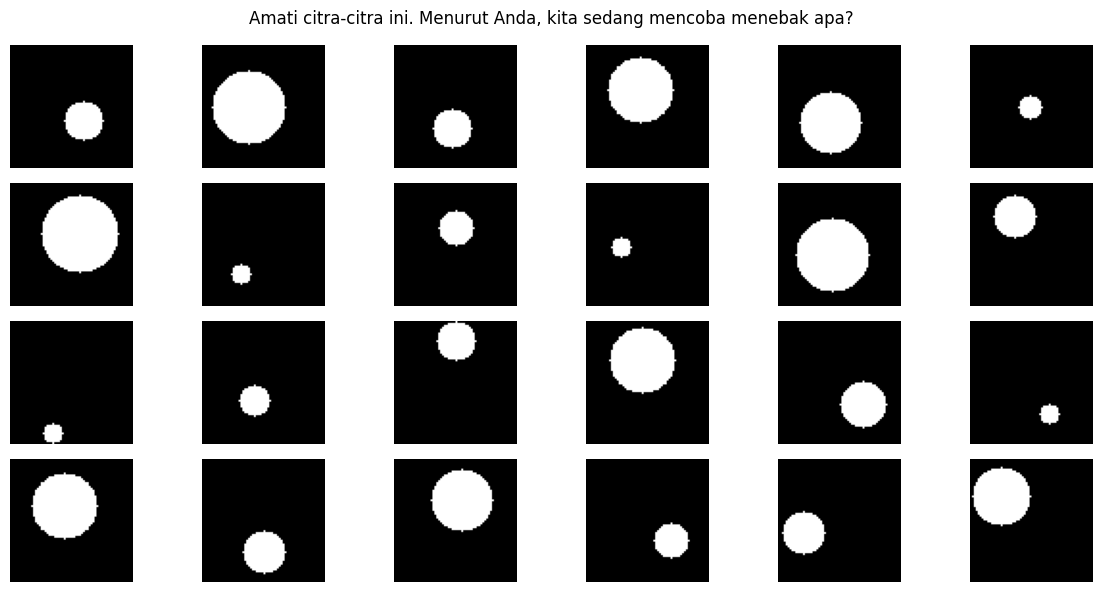

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

Variabel kontinu yang diprediksi adalah radius(rads).

Diskusi cepat (di kelas):
1. Apakah yang berubah dari gambar ke gambar?
**jawaban :** ukuran lingkaran(besar-kecilnya), posisi pusat lingkaran yang berbeda - beda.

2. Apakah ukuran lingkaran berkaitan dengan sesuatu yang bisa “diukur” sebagai angka?
**jawaban:** iyaa, nilai radius yang disimpan di var rads
3. Apakah posisi pusat juga bisa jadi target?
**jawaban :** bisa, posisi pusat bisa dijadikan target karena merupakan nilai kontinu (koordinat x dan y).
Tetapi dalam kode dan visualisasi ini, target yang sebenarnya ingin diprediksi adalah radius lingkaran (rads), bukan posisi pusatnya.

###3)Buka Jawaban — Target yang Ingin Diprediksi

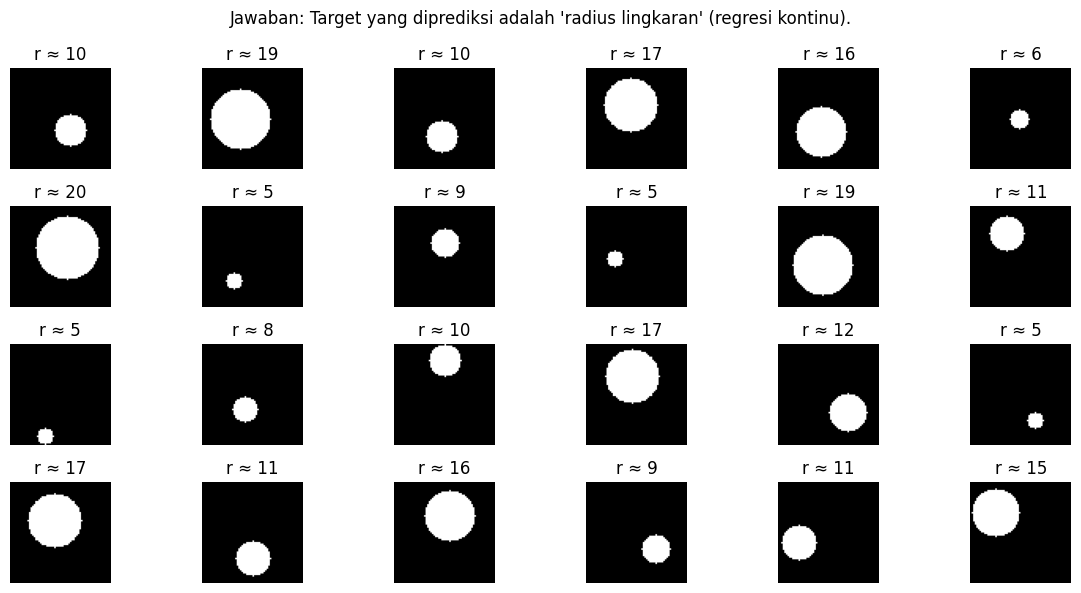

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

###4)(Opsional) Latih CNN Kecil untuk Memprediksi Radius

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([ layers.Input((64,64,3)),
                          layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
                          layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
                          layers.Conv2D(128, 3, activation='relu'),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE=0.908 | RMSE=1.101 | R²=0.939


###Plot history & True vs Predicted:

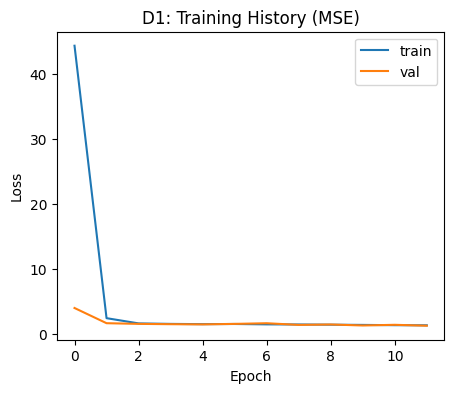

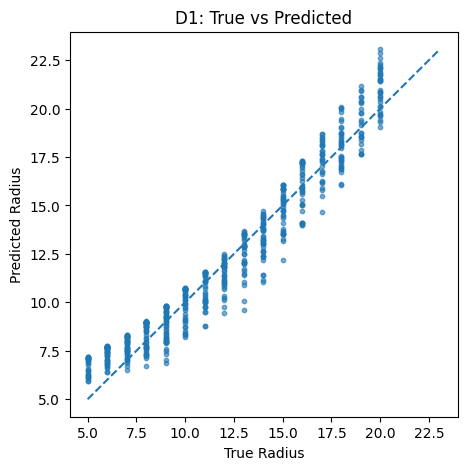

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

###5) Tantangan Mini (Opsional untuk Mahasiswa)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import models, layers

# Fungsi pembuat sampel data (dengan blur + noise)
def make_sample(img_size=64):
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)

    r = np.random.uniform(8, 28)
    cx = np.random.randint(int(r)+1, img_size-int(r)-1)
    cy = np.random.randint(int(r)+1, img_size-int(r)-1)

    color = tuple(np.random.randint(0, 256, size=3).tolist())
    cv2.circle(img, (cx, cy), int(r), color, -1)

    # Gaussian blur
    img = cv2.GaussianBlur(img, (5,5), 0)

    # Gaussian noise (mean=0, std=0.05)
    noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
    img = np.clip(img/255.0 + noise, 0, 1)

    return img, (r, cx, cy), color

#  Dataset
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN multi-output
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=1)

# Evaluasi
y_pred = model.predict(Xte)
mae_r = mean_absolute_error(yte[:,0], y_pred[:,0])
mae_cx = mean_absolute_error(yte[:,1], y_pred[:,1])
mae_cy = mean_absolute_error(yte[:,2], y_pred[:,2])
mae_avg = np.mean([mae_r, mae_cx, mae_cy])

r2_r = r2_score(yte[:,0], y_pred[:,0])
r2_cx = r2_score(yte[:,1], y_pred[:,1])
r2_cy = r2_score(yte[:,2], y_pred[:,2])
r2_avg = np.mean([r2_r, r2_cx, r2_cy])

dist_error = np.mean(np.linalg.norm(y_pred - yte, axis=1))

print(f"MAE_r={mae_r:.3f}, MAE_cx={mae_cx:.3f}, MAE_cy={mae_cy:.3f}, MAE_avg={mae_avg:.3f}")
print(f"R²_r={r2_r:.3f}, R²_cx={r2_cx:.3f}, R²_cy={r2_cy:.3f}, R²_avg={r2_avg:.3f}")
print(f"Mean Euclidean Distance Error = {dist_error:.3f}")


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 581ms/step - loss: 639.7142 - mae: 22.4172 - val_loss: 122.6560 - val_mae: 7.8650
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step - loss: 99.0717 - mae: 7.2669 - val_loss: 57.9365 - val_mae: 6.1162
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step - loss: 59.7399 - mae: 6.2161 - val_loss: 57.1957 - val_mae: 5.9718
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - loss: 54.8779 - mae: 5.8463 - val_loss: 54.9221 - val_mae: 5.8026
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step - loss: 55.4795 - mae: 5.8434 - val_loss: 51.2020 - val_mae: 5.5221
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 515ms/step - loss: 50.9432 - mae: 5.5022 - val_loss: 48.4131 - val_mae: 5.2295
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 462ms/step - loss: 48.2440 - mae: 5.2583 - val_loss: 46.9702 - val_mae: 5.0112
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - loss: 49.8197 - mae: 5.1660 - val_loss: 45.1341 - val_mae: 4.8304
Epoch 9/12
38/38 ━━━━━━━━━━━━

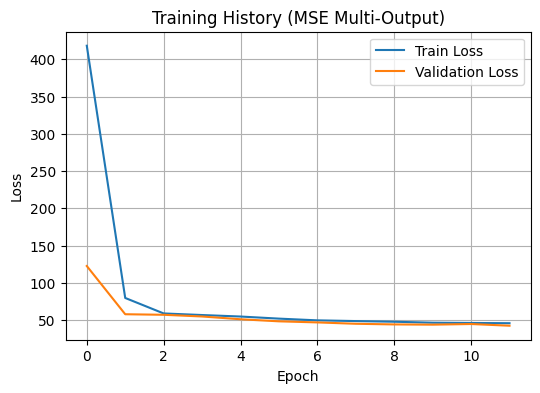

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


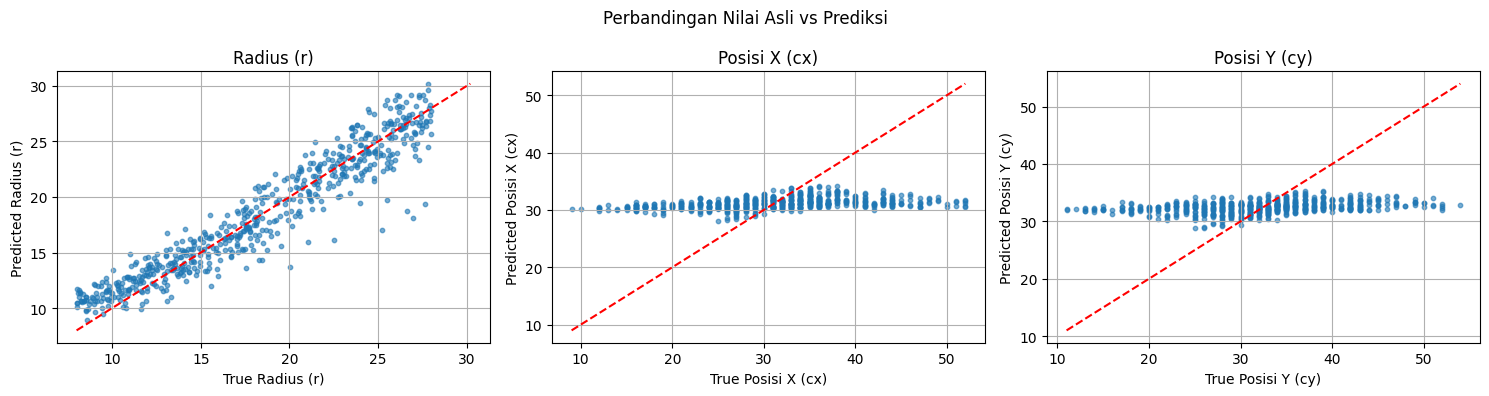

In [3]:
#Visualisasi hasil pelatihan & evaluasi model
import matplotlib.pyplot as plt

# --- Plot grafik loss (MSE) ---
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training History (MSE Multi-Output)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Scatter plot True vs Predicted untuk tiap output ---
y_pred = model.predict(Xte)

labels = ['Radius (r)', 'Posisi X (cx)', 'Posisi Y (cy)']
plt.figure(figsize=(15,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(yte[:, i], y_pred[:, i], s=10, alpha=0.6)
    lims = [
        min(yte[:, i].min(), y_pred[:, i].min()),
        max(yte[:, i].max(), y_pred[:, i].max())
    ]
    plt.plot(lims, lims, 'r--')
    plt.xlabel(f"True {labels[i]}")
    plt.ylabel(f"Predicted {labels[i]}")
    plt.title(f"{labels[i]}")
    plt.grid(True)

plt.suptitle("Perbandingan Nilai Asli vs Prediksi")
plt.tight_layout()
plt.show()


##Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

###Langkah 2 — Mengunggah kaggle.json ke Colab

In [ ]:
#Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"putrilevinaa","key":"eea69ab136245c765279cc40306a5968"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
      os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
      shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
      os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
      !pip -q install kaggle
      print("✅ Kaggle API siap digunakan.")
else:
      print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


###Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


###E.Langkah 4 — Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


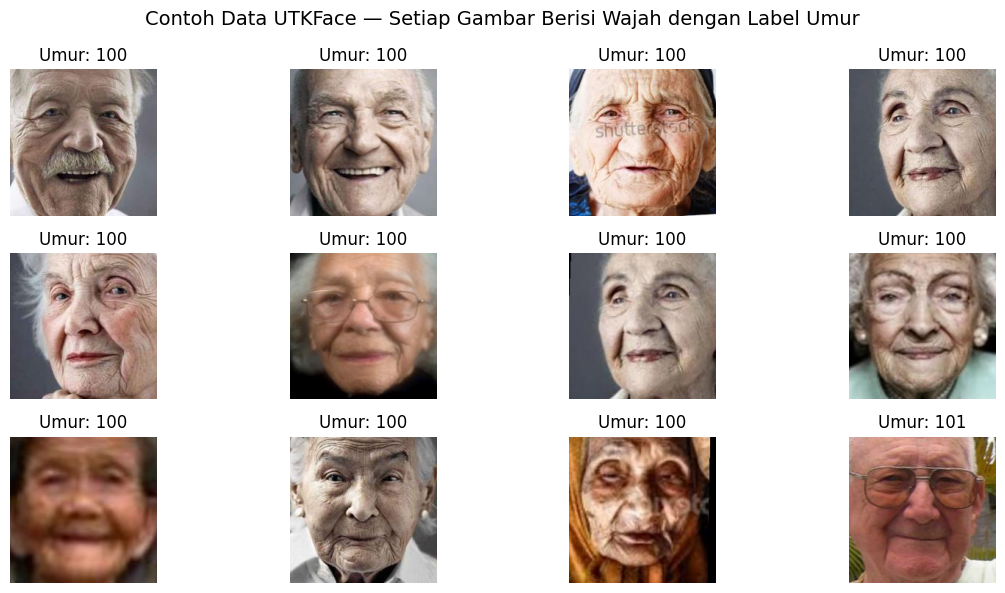

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
   # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

###Langkah 5 — Siapkan Dataset untuk Model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


###Langkah 6 — Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            weights='imagenet')
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mse', metrics=['mae'])

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

###Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 143ms/step - loss: 323.5641 - mae: 13.2125 - val_loss: 158.6147 - val_mae: 9.5860 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 151.7122 - mae: 9.1492 - val_loss: 143.7574 - val_mae: 8.9076 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 143.0233 - mae: 8.8215 - val_loss: 142.2781 - val_mae: 8.8933 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 140.9915 - mae: 8.7352 - val_loss: 140.3758 - val_mae: 8.8482 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 138.9361 - mae: 8.6368 - val_loss: 136.1980 - val_mae: 8.5872 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 134.8299 - mae: 8.5030 - val_loss: 136.6753 - val_mae: 8.6730 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 133.4197 - mae: 8.4262 - val_loss: 135.4061 - va

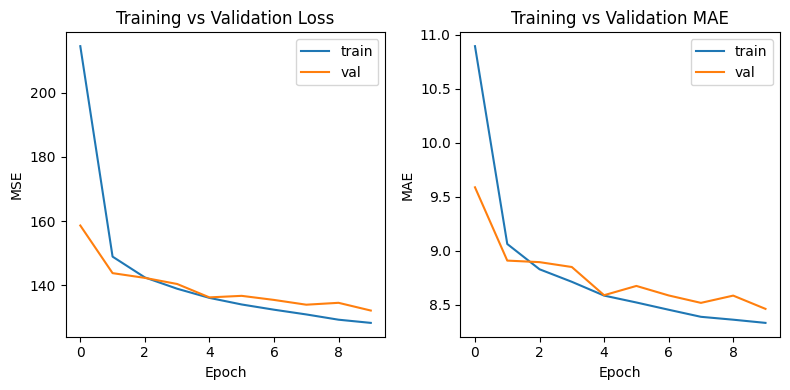

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


###Langkah 8 — Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 192.4681 - mae: 10.2026 - val_loss: 148.1610 - val_mae: 8.7745 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 78.0915 - mae: 6.5447 - val_loss: 122.6711 - val_mae: 8.2887 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 52.3444 - mae: 5.4098 - val_loss: 142.4723 - val_mae: 9.0720 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - loss: 39.3675 - mae: 4.7070 - val_loss: 103.4789 - val_mae: 7.4470 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 30.6294 - mae: 4.1570 - val_loss: 107.0121 - val_mae: 7.4843 - learning_rate: 1.0000e-04


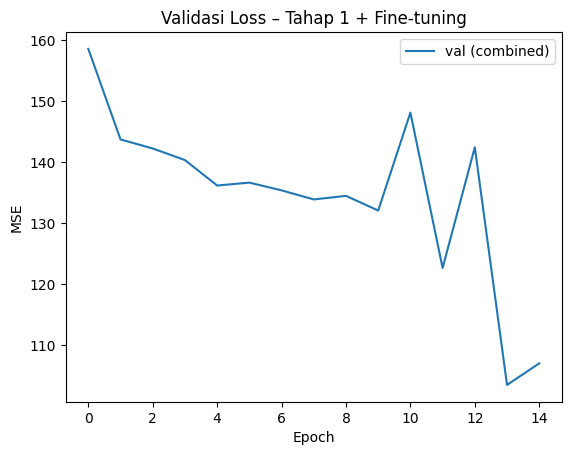

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(
    history.history['val_loss'] + history_ft.history['val_loss'],
    label='val (combined)'
)
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


###Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

MAE = 7.45 tahun
RMSE = 10.17 tahun
R2 = 0.739


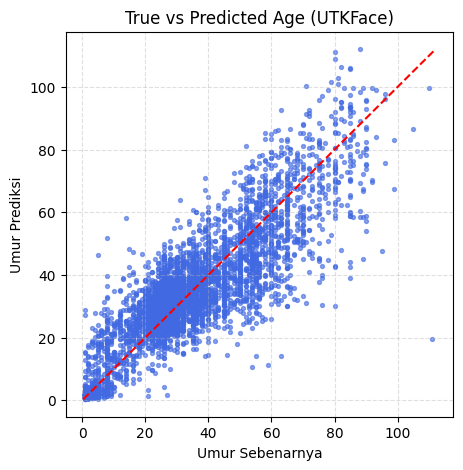

In [ ]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

###Langkah 10 — Melihat Contoh Prediksi Nyata

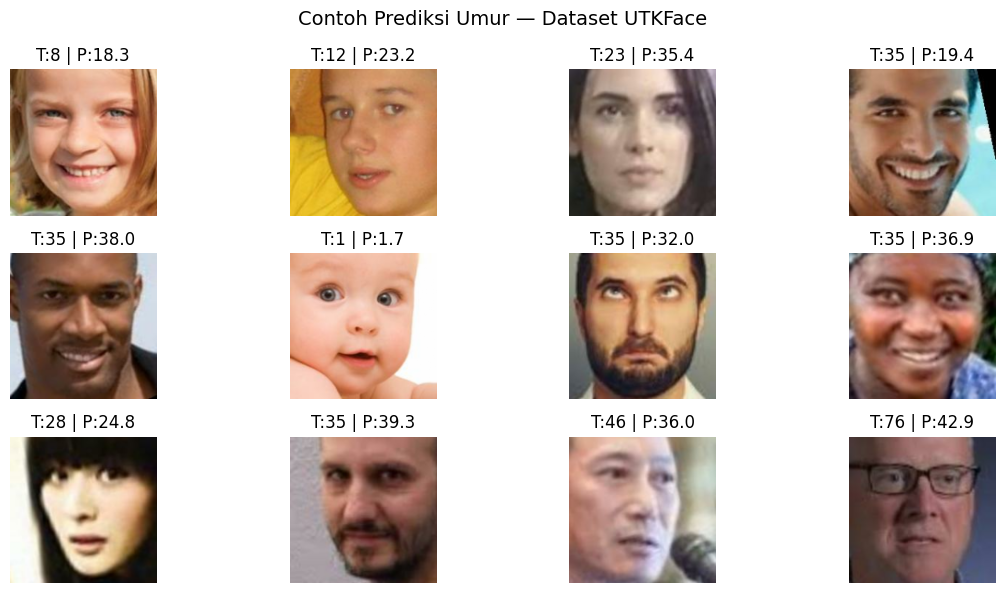

In [ ]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

###Tantangan Mini (Opsional)

1.Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2.Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3.Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4.Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?

Total gambar ditemukan: 23708


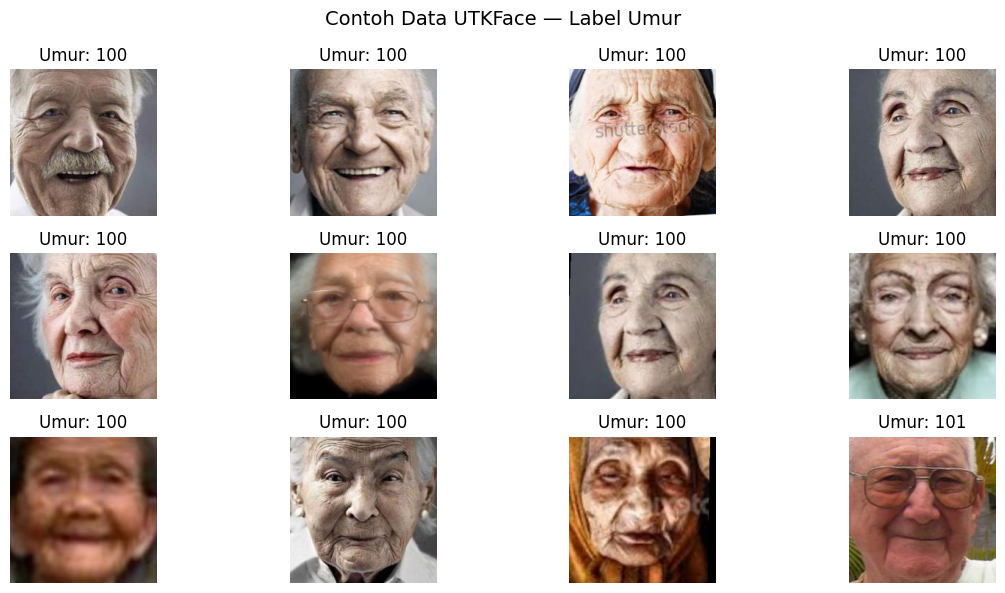

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import os, glob, random
from PIL import Image
from math import sqrt

# Load dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160

# Data augmentation tambahan
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2)
])

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return data_augmentation(img), label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap digunakan")


✅ Dataset siap digunakan


In [ ]:
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# ✅ Learning rate tetap — biar ReduceLROnPlateau bisa bekerja
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# Callback tetap sama
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5)
]


Hardware: GPU


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_2 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 194s 621ms/step - loss: 507.5310 - mae: 17.1379 - val_loss: 397.1977 - val_mae: 15.8282 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 180s 608ms/step - loss: 398.8800 - mae: 15.3168 - val_loss: 392.5015 - val_mae: 15.6714 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 173s 584ms/step - loss: 396.6230 - mae: 15.2605 - val_loss: 394.4106 - val_mae: 15.7708 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 580ms/step - loss: 395.7215 - mae: 15.2610 - val_loss: 389.3345 - val_mae: 15.5782 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 173s 583ms/step - loss: 394.8257 - mae: 15.2273 - val_loss: 388.0468 - val_mae: 15.5848 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 171s 577ms/step - loss: 394.0378 - mae: 15.2305 - val_loss: 389.9197 - val_mae: 15.6201 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 580ms/step - loss: 394.8737 - mae: 15.2290 

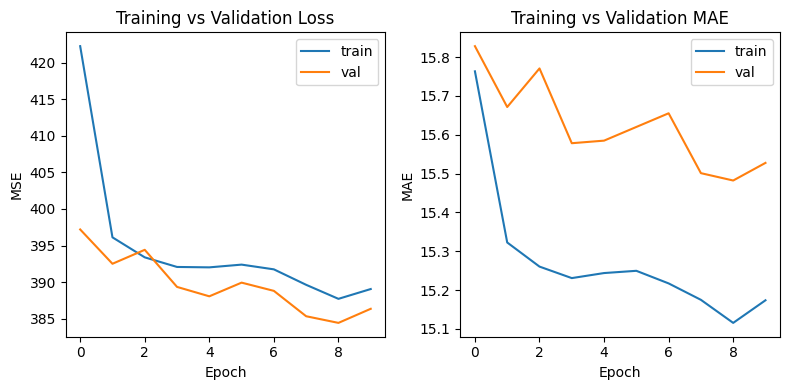

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Plot hasil training
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title('Training vs Validation Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE'); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 208s 641ms/step - loss: 418.8501 - mae: 15.7333 - val_loss: 418.6363 - val_mae: 15.1357 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 176s 590ms/step - loss: 391.4054 - mae: 15.1821 - val_loss: 426.3214 - val_mae: 15.5736 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 175s 591ms/step - loss: 381.5608 - mae: 15.0402 - val_loss: 639.7645 - val_mae: 19.5824 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 177s 596ms/step - loss: 362.2852 - mae: 14.6369 - val_loss: 489.8066 - val_mae: 16.9457 - learning_rate: 5.0000e-05


MAE = 15.10 tahun
RMSE = 20.47 tahun
R2 = -0.056


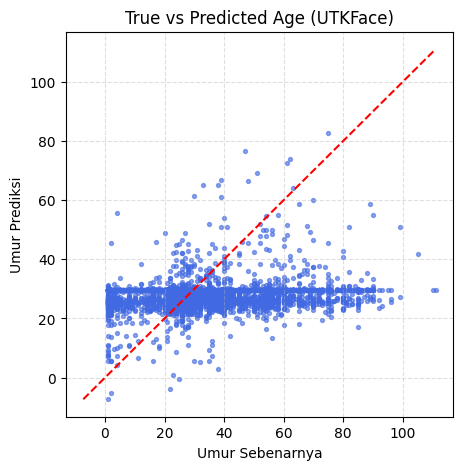

In [ ]:
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya"); plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()



📊 MAE per Kelompok Umur:
Kelompok umur 0–10: MAE = 23.46 tahun
Kelompok umur 11–20: MAE = 12.81 tahun
Kelompok umur 21–30: MAE = 3.82 tahun
Kelompok umur 31–40: MAE = 6.33 tahun
Kelompok umur 41–50: MAE = 15.18 tahun
Kelompok umur 51–60: MAE = 25.30 tahun
Kelompok umur 61+: MAE = 41.73 tahun


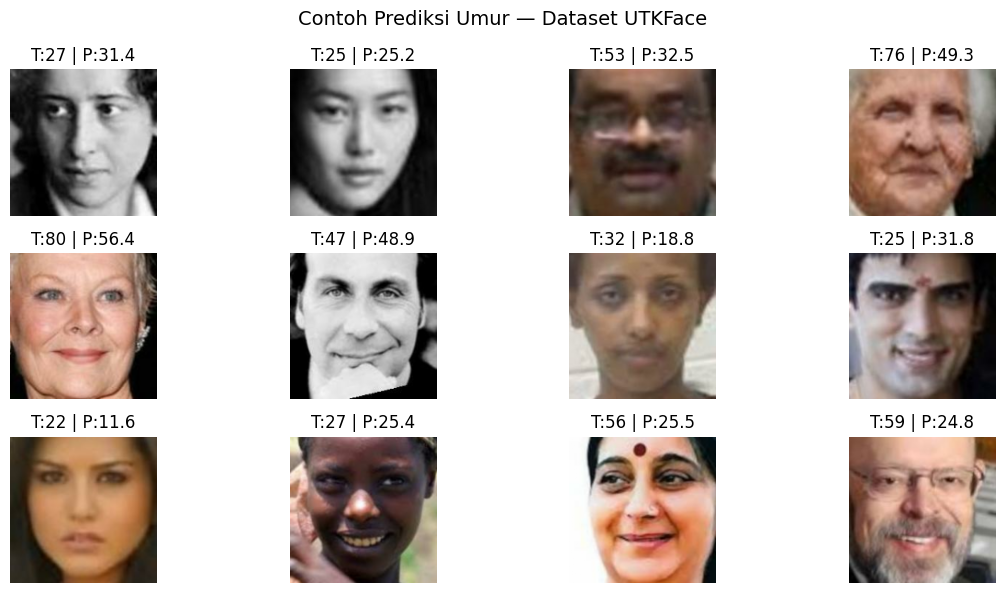

In [ ]:
# Analisis per kelompok umur
bins = [0, 10, 20, 30, 40, 50, 60, 100]
labels = ["0–10", "11–20", "21–30", "31–40", "41–50", "51–60", "61+"]
y_test_group = np.digitize(y_test, bins)

print("\n📊 MAE per Kelompok Umur:")
for i, name in enumerate(labels, 1):
    mask = (y_test_group == i)
    if np.sum(mask) == 0:
        continue
    mae_group = mean_absolute_error(y_test[mask], y_pred[mask])
    print(f"Kelompok umur {name}: MAE = {mae_group:.2f} tahun")

# Contoh prediksi gambar
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout(); plt.show()


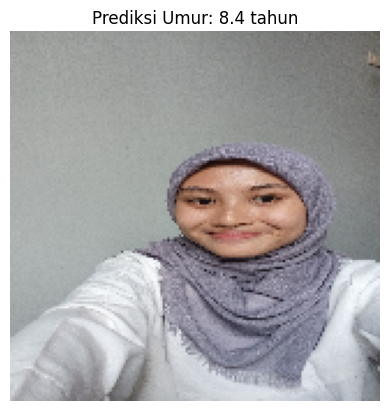

In [ ]:
img_path = "wajah_saya.jpg"
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
plt.imshow(img.numpy())
plt.title(f"Prediksi Umur: {pred_age:.1f} tahun")
plt.axis("off")
plt.show()

##Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

###Langkah 1 — Menyiapkan Kaggle API

In [ ]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


###Langkah 2 — Mengunduh dan Mengekstrak Dataset

In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


###Langkah 3 — Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

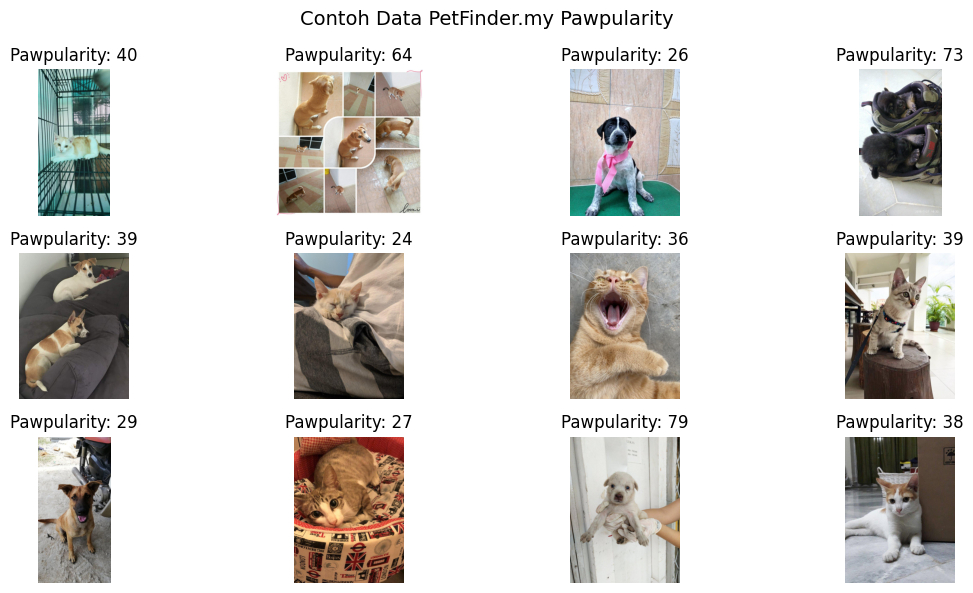

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

###Langkah 4 — Persiapan Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


###Langkah 4 — Membangun Model (EfficientNetB0)

In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

###Langkah 5 — Melatih Model

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3,
restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10,
callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 111s 520ms/step - loss: 836.1915 - mae: 21.7219 - val_loss: 478.6530 - val_mae: 16.0861 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - loss: 428.9459 - mae: 15.3204 - val_loss: 426.5393 - val_mae: 15.1717 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - loss: 382.0114 - mae: 14.5023 - val_loss: 404.3843 - val_mae: 14.8602 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 209ms/step - loss: 370.7802 - mae: 14.3328 - val_loss: 389.9442 - val_mae: 14.5642 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - loss: 361.3418 - mae: 14.1126 - val_loss: 383.9019 - val_mae: 14.1972 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - loss: 354.5468 - mae: 13.9391 - val_loss: 378.1980 - val_mae: 14.3970 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - loss: 340.2956 - mae: 13.7290 - val_

###Langkah 6 — Melihat Proses Belajar

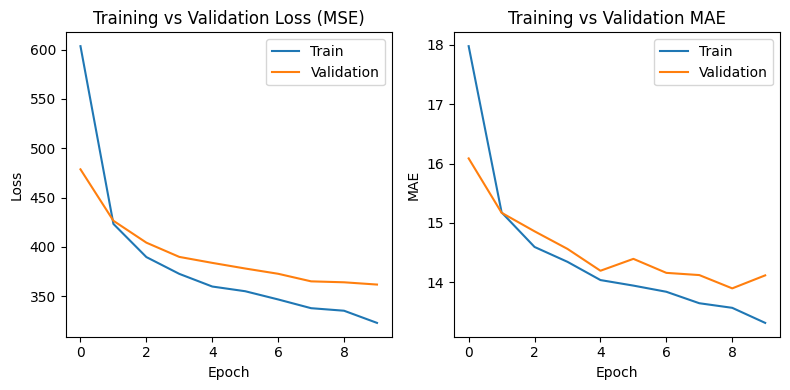

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

###Langkah 7 — Evaluasi Model

MAE = 14.12
RMSE = 19.02
R2 = 0.181


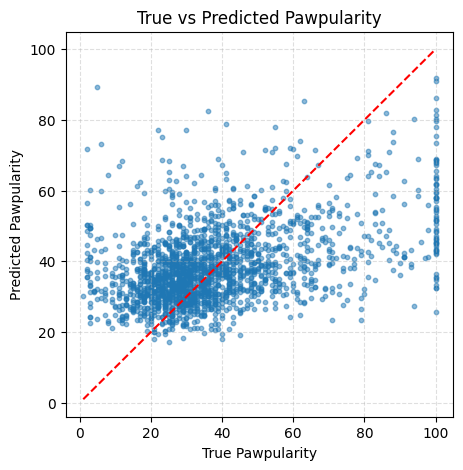

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R2 = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

###Langkah 8 — Melihat Contoh Prediksi

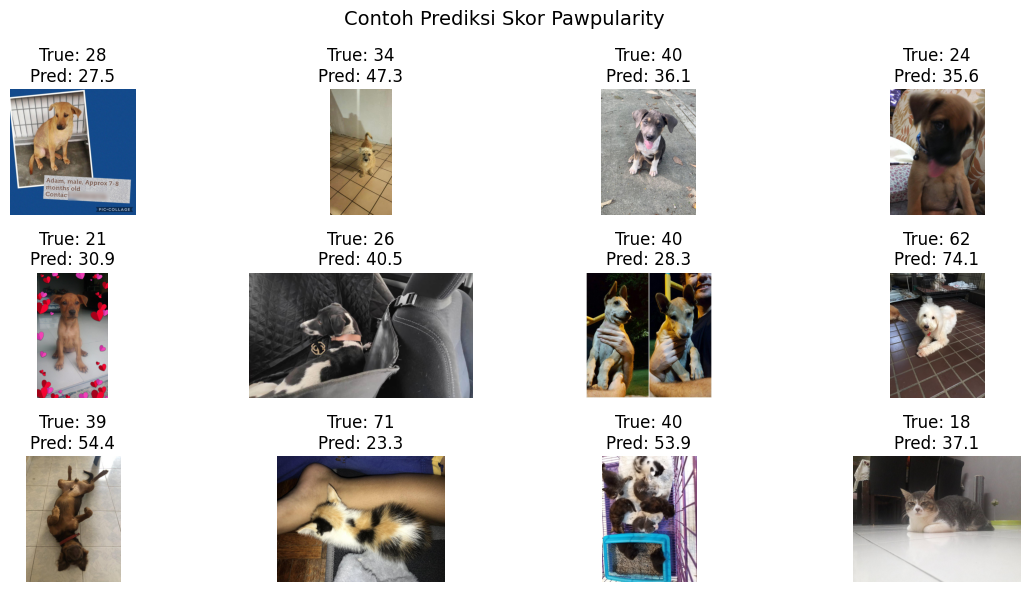

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path,
    row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

###Tantangan Mini

1. Coba tambahkan data augmentation agar model tidak bosan dengan pola yang sama.
2. Gunakan EfficientNetB3 atau ResNet50, lalu bandingkan hasilnya.
3. Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu
spesies?
4. Tambahkan fitur non-visual (misal brightness rata-rata) ke model regresi.


####tantangan1

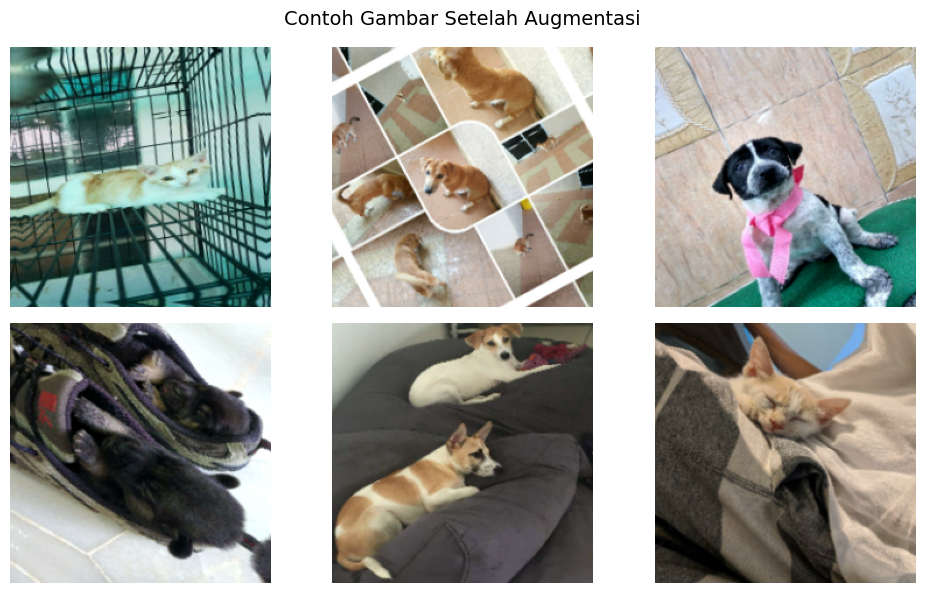

In [ ]:
# --- Tantangan Mini 1: Data Augmentation  ---
from tensorflow.keras import layers

# Definisikan augmentasi dengan rentang input 0–1
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Contoh augmentasi 6 gambar acak
sample_paths = df['path'].sample(6, random_state=42).values

plt.figure(figsize=(10, 6))
for i, path in enumerate(sample_paths):
    img = tf.expand_dims(load_image(path, 0)[0], 0)  # sudah di-normalisasi 0–1
    aug_img = data_augmentation(img, training=True)  # aktifkan augmentasi
    plt.subplot(2, 3, i + 1)
    plt.imshow(aug_img[0])
    plt.axis('off')
plt.suptitle("Contoh Gambar Setelah Augmentasi", fontsize=14)
plt.tight_layout()
plt.show()


####Tantangan2

In [ ]:
# --- Tantangan Mini 2: Bandingkan EfficientNetB3 dan ResNet50 ---

def build_model(backbone_name="EfficientNetB3"):
    if backbone_name == "EfficientNetB3":
        base = tf.keras.applications.EfficientNetB3(
            include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
        preprocess = tf.keras.applications.efficientnet.preprocess_input
    elif backbone_name == "ResNet50":
        base = tf.keras.applications.ResNet50(
            include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
        preprocess = tf.keras.applications.resnet.preprocess_input
    else:
        raise ValueError("Backbone tidak dikenali")

    base.trainable = False

    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess(x * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
# --- Training singkat untuk perbandingan ---
models_result = {}

for backbone in ["EfficientNetB3", "ResNet50"]:
    print(f"\n🚀 Melatih model dengan backbone {backbone}")
    model = build_model(backbone)
    history = model.fit(
        train_ds, validation_data=val_ds,
        epochs=5, callbacks=cb, verbose=1)
    models_result[backbone] = history.history



🚀 Melatih model dengan backbone EfficientNetB3
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - loss: 931.4976 - mae: 23.0619 - val_loss: 526.4821 - val_mae: 16.3199 - learning_rate: 0.0010
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 58s 364ms/step - loss: 456.2820 - mae: 15.7323 - val_loss: 445.9117 - val_mae: 15.3712 - learning_rate: 0.0010
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 56s 354ms/step - loss: 407.7521 - mae: 15.0207 - val_loss: 409.3490 - val_mae: 14.9227 - learning_rate: 0.0010
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - loss: 385.4126 - mae: 14.6784 - val_loss: 394.0475 - val_mae: 14.4991 - learning_rate: 0.0010
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - loss: 381.8317 - mae: 14.5569 - val_loss: 380.0893 - val_mae: 14.2930 - learning_rate: 0.0010

🚀 Melatih model dengan backbone ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 70s 388ms/step - lo

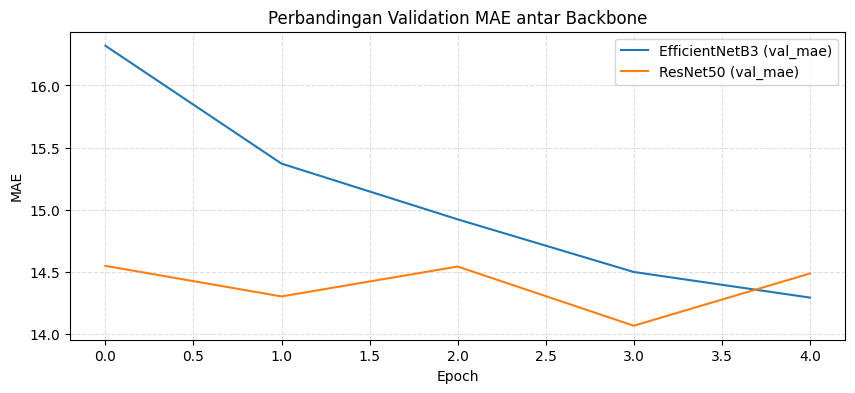

In [ ]:
# --- Plot perbandingan hasil ---
plt.figure(figsize=(10,4))
for backbone, history in models_result.items():
    plt.plot(history['val_mae'], label=f'{backbone} (val_mae)')
plt.title("Perbandingan Validation MAE antar Backbone")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


####Tantangan3

Species
cat    9912
Name: count, dtype: int64


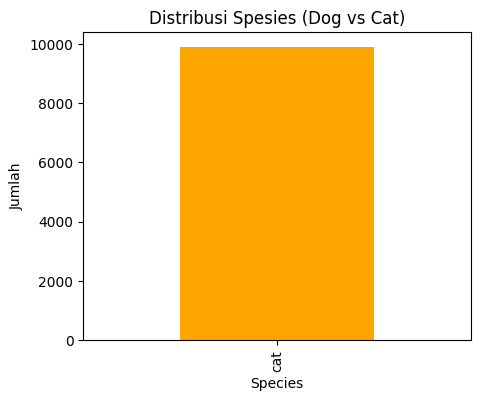

⚠️ Tidak ditemukan cukup data Dog atau Cat untuk evaluasi bias.


In [ ]:
# --- Tantangan Mini 3: Analisis Bias Anjing vs Kucing ---

# Deteksi species dari path (tidak case-sensitive)
df['Species'] = df['path'].apply(lambda x: 'dog' if 'dog' in x.lower() else 'cat')

# Hitung distribusi
species_count = df['Species'].value_counts()
print(species_count)

# Visualisasi distribusi spesies
plt.figure(figsize=(5,4))
species_count.plot(kind='bar', color=['orange', 'blue'])
plt.title("Distribusi Spesies (Dog vs Cat)")
plt.ylabel("Jumlah")
plt.show()


# --- Evaluasi bias model pada tiap spesies ---
# Prediksi untuk data validasi
y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel()
    for batch in val_ds
])

# Tambahkan prediksi ke val_df
val_df['pred'] = y_pred

# Pastikan kolom 'species' ada di val_df juga
val_df = val_df.merge(df[['path', 'species']], on='path', how='left')

# Pisahkan dog dan cat
dog_df = val_df[val_df['species'] == 'dog']
cat_df = val_df[val_df['species'] == 'cat']

# Hitung MAE masing-masing
from sklearn.metrics import mean_absolute_error

if len(dog_df) > 0 and len(cat_df) > 0:
    mae_dog = mean_absolute_error(dog_df['Pawpularity'], dog_df['pred'])
    mae_cat = mean_absolute_error(cat_df['Pawpularity'], cat_df['pred'])
    print(f"Dog MAE : {mae_dog:.2f}")
    print(f"Cat MAE : {mae_cat:.2f}")
    print(f"Bias model: {'Dog' if mae_dog > mae_cat else 'Cat'} lebih sulit diprediksi.")
else:
    print("⚠️ Tidak ditemukan cukup data Dog atau Cat untuk evaluasi bias.")


####Tantangan4

In [ ]:
import numpy as np
from tqdm import tqdm
from PIL import Image

def compute_brightness(path):
    try:
        img = Image.open(path).convert('L')  # ubah ke grayscale
        return np.array(img).mean() / 255.0  # normalisasi 0–1
    except:
        return np.nan

# Hitung brightness untuk semua gambar (ini mungkin butuh 1–2 menit)
df['brightness'] = [compute_brightness(p) for p in tqdm(df['path'])]

# Cek hasil
df[['path', 'brightness', 'Pawpularity']].head()


100%|██████████| 9912/9912 [00:59<00:00, 166.48it/s]


path  brightness  Pawpularity
0  /content/paw/train/0007de18844b0dbbb5e1f607da0...    0.586808           63
1  /content/paw/train/0009c66b9439883ba2750fb825e...    0.374783           42
2  /content/paw/train/0013fd999caf9a3efe1352ca1b0...    0.460498           28
3  /content/paw/train/0018df346ac9c1d8413cfcc888c...    0.615579           15
4  /content/paw/train/001dc955e10590d3ca4673f034f...    0.507037           72

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_df, val_df = train_test_split(df.dropna(subset=['brightness']), test_size=0.2, random_state=42)

IMG_SIZE = 224

def load_with_brightness(path, brightness, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return (img, tf.cast([brightness], tf.float32)), tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['brightness'], train_df['Pawpularity']))\
    .map(load_with_brightness, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['brightness'], val_df['Pawpularity']))\
    .map(load_with_brightness, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False

# Input gambar
img_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(img_input * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)

# Input non-visual (brightness)
b_input = tf.keras.Input(shape=(1,))
b = layers.Dense(8, activation='relu')(b_input)

# Gabungkan dua input
combined = layers.Concatenate()([x, b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1)(combined)

model2 = tf.keras.Model(inputs=[img_input, b_input], outputs=output)
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])
model2.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 224, 224,  │          0 │ input_layer_16[0… │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ multiply_3[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    327,936 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         16 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 264)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     33,920 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,411,572 (16.83 MB)

 Trainable params: 362,001 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 89s 218ms/step - loss: 620.0334 - mae: 18.2194 - val_loss: 375.5265 - val_mae: 14.1355 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - loss: 360.9495 - mae: 13.9930 - val_loss: 355.8581 - val_mae: 13.9359 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - loss: 328.1227 - mae: 13.4759 - val_loss: 347.1852 - val_mae: 13.7519 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - loss: 303.7024 - mae: 12.8957 - val_loss: 368.1371 - val_mae: 13.7963 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - loss: 285.5330 - mae: 12.5553 - val_loss: 356.7411 - val_mae: 13.5679 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - loss: 274.1923 - mae: 12.2704 - val_loss: 353.1236 - val_mae: 13.5438 - learning_rate: 5.0000e-04


In [ ]:
y_true = val_df['Pawpularity'].values
y_pred = np.concatenate([model2.predict((batch[0][0], batch[0][1]), verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


MAE  = 13.75
RMSE = 18.63
R²   = 0.215


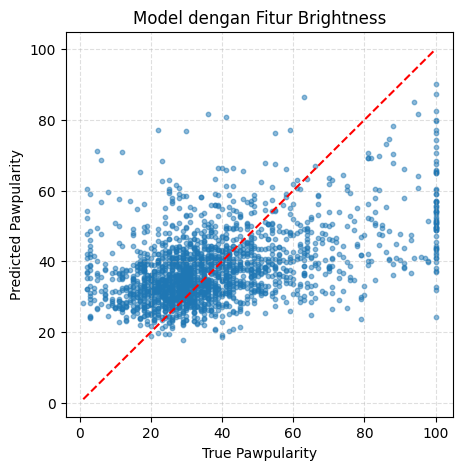

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model dengan Fitur Brightness")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


##Penugasan 1

In [ ]:
# Upload foto pribadi untuk prediksi umur
from google.colab import files
import os

uploaded = files.upload()

# Deteksi otomatis nama file yang di-upload
for fname in uploaded.keys():
    my_photo_path = f"/content/{fname}"
    print(f"✅ File '{fname}' berhasil diunggah dan disimpan sebagai {my_photo_path}")


Saving foto_selfie.jpeg to foto_selfie.jpeg
✅ File 'foto_selfie.jpeg' berhasil diunggah dan disimpan sebagai /content/foto_selfie.jpeg


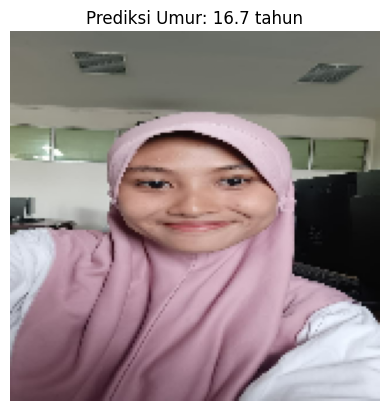

In [ ]:
# Prediksi umur dari foto pribadi menggunakan hp
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = 160  # sama seperti model UTKFace

img = tf.io.read_file(my_photo_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

plt.imshow(img.numpy())
plt.title(f"Prediksi Umur: {pred_age:.1f} tahun")
plt.axis("off")
plt.show()


In [ ]:
# Upload foto pribadi untuk prediksi umur
from google.colab import files
import os

uploaded = files.upload()

# Deteksi otomatis nama file yang di-upload
for fname in uploaded.keys():
    my_photo_path = f"/content/{fname}"
    print(f"✅ File '{fname}' berhasil diunggah dan disimpan sebagai {my_photo_path}")


Saving foto_saya.jpeg to foto_saya.jpeg
✅ File 'foto_saya.jpeg' berhasil diunggah dan disimpan sebagai /content/foto_saya.jpeg


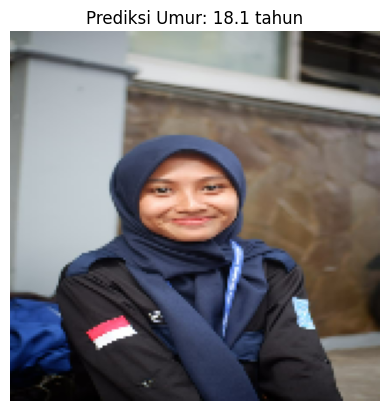

In [ ]:
# Prediksi umur dari foto pribadi menggunakan kamera
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = 160  # sama seperti model UTKFace

img = tf.io.read_file(my_photo_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

plt.imshow(img.numpy())
plt.title(f"Prediksi Umur: {pred_age:.1f} tahun")
plt.axis("off")
plt.show()


##Penugasan 2

In [ ]:
# Upload foto peliharaan pribadi
from google.colab import files
import os

print("Silakan upload foto peliharaan (anjing/kucing/dll)")
uploaded = files.upload()  # pilih 1 file gambar (.jpg/.jpeg/.png)

# Deteksi otomatis nama file
for fname in uploaded.keys():
    pet_path = f"/content/{fname}"
    print(f"✅ File '{fname}' berhasil diunggah ke {pet_path}")


Silakan upload foto peliharaan (anjing/kucing/dll)


Saving siboy.jpg to siboy.jpg
✅ File 'siboy.jpg' berhasil diunggah ke /content/siboy.jpg


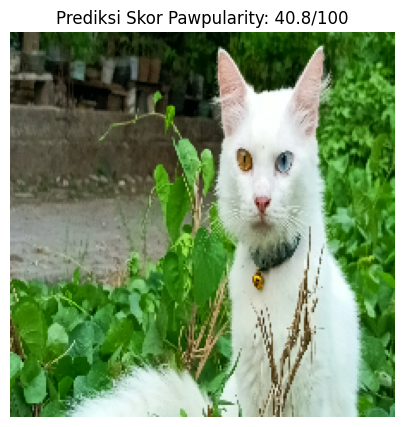

Skor prediksi foto peliharaan kamu: 40.8 dari 100.


In [ ]:
# Prediksi skor Pawpularity dari foto pribadi
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 224  # ukuran input model Pawpularity (EfficientNetB0)

# Pastikan variabel pet_path sudah ada dari cell sebelumnya
if 'pet_path' not in locals():
    raise ValueError("❌ Belum ada foto diunggah! Jalankan cell upload dulu.")

# Baca dan siapkan gambar
img = tf.io.read_file(pet_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

# Prediksi skor (0–100)
pred_score = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

# Tampilkan hasil
plt.figure(figsize=(5,5))
plt.imshow(img.numpy())
plt.title(f"Prediksi Skor Pawpularity: {pred_score:.1f}/100", fontsize=12)
plt.axis("off")
plt.show()

print(f"Skor prediksi foto peliharaan kamu: {pred_score:.1f} dari 100.")
